In [1]:
# Reference: https://www.youtube.com/watch?v=sttf-Rgfl1Q&t=1147s

import os
import numpy as np 
import pandas as pd
import mne
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
fname = r"D:\GitHub\EEG_fatigue\data\EEG_sample_data\raw_data\03Wangyuwen.vhdr"

# Read and Visualize

In [3]:
# By default, MNE does not store raw and epochs objects in memory. If necessary, set preload=True.
raw = mne.io.read_raw_brainvision(fname)

Extracting parameters from D:\GitHub\EEG_fatigue\data\EEG_sample_data\raw_data\03Wangyuwen.vhdr...
Setting channel info structure...


<ipython-input-3-005bc6ce8395>:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(fname)


In [4]:
montage = mne.channels.make_standard_montage('standard_1005')

In [5]:
fig = montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 339 unique labels.
Creating RawArray with float64 data, n_channels=339, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 339 unique labels.
Creating RawArray with float64 data, n_channels=339, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


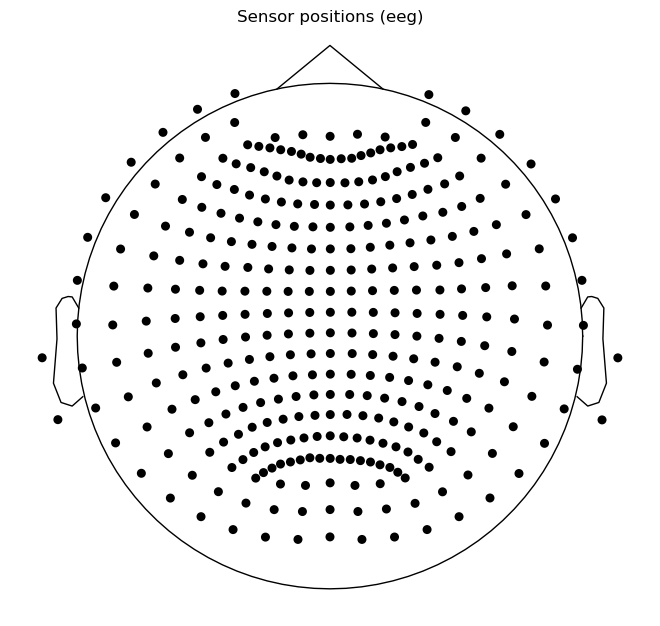

In [6]:
montage.plot(kind='topomap', show_names=False)

In [7]:
raw_1005 = raw.copy().set_montage('standard_1005') # set montage, or use 

In [8]:
data = raw_1005.crop(tmin=60,tmax=660).load_data() # time range: (1,10) minutes

Reading 0 ... 600000  =      0.000 ...   600.000 secs...


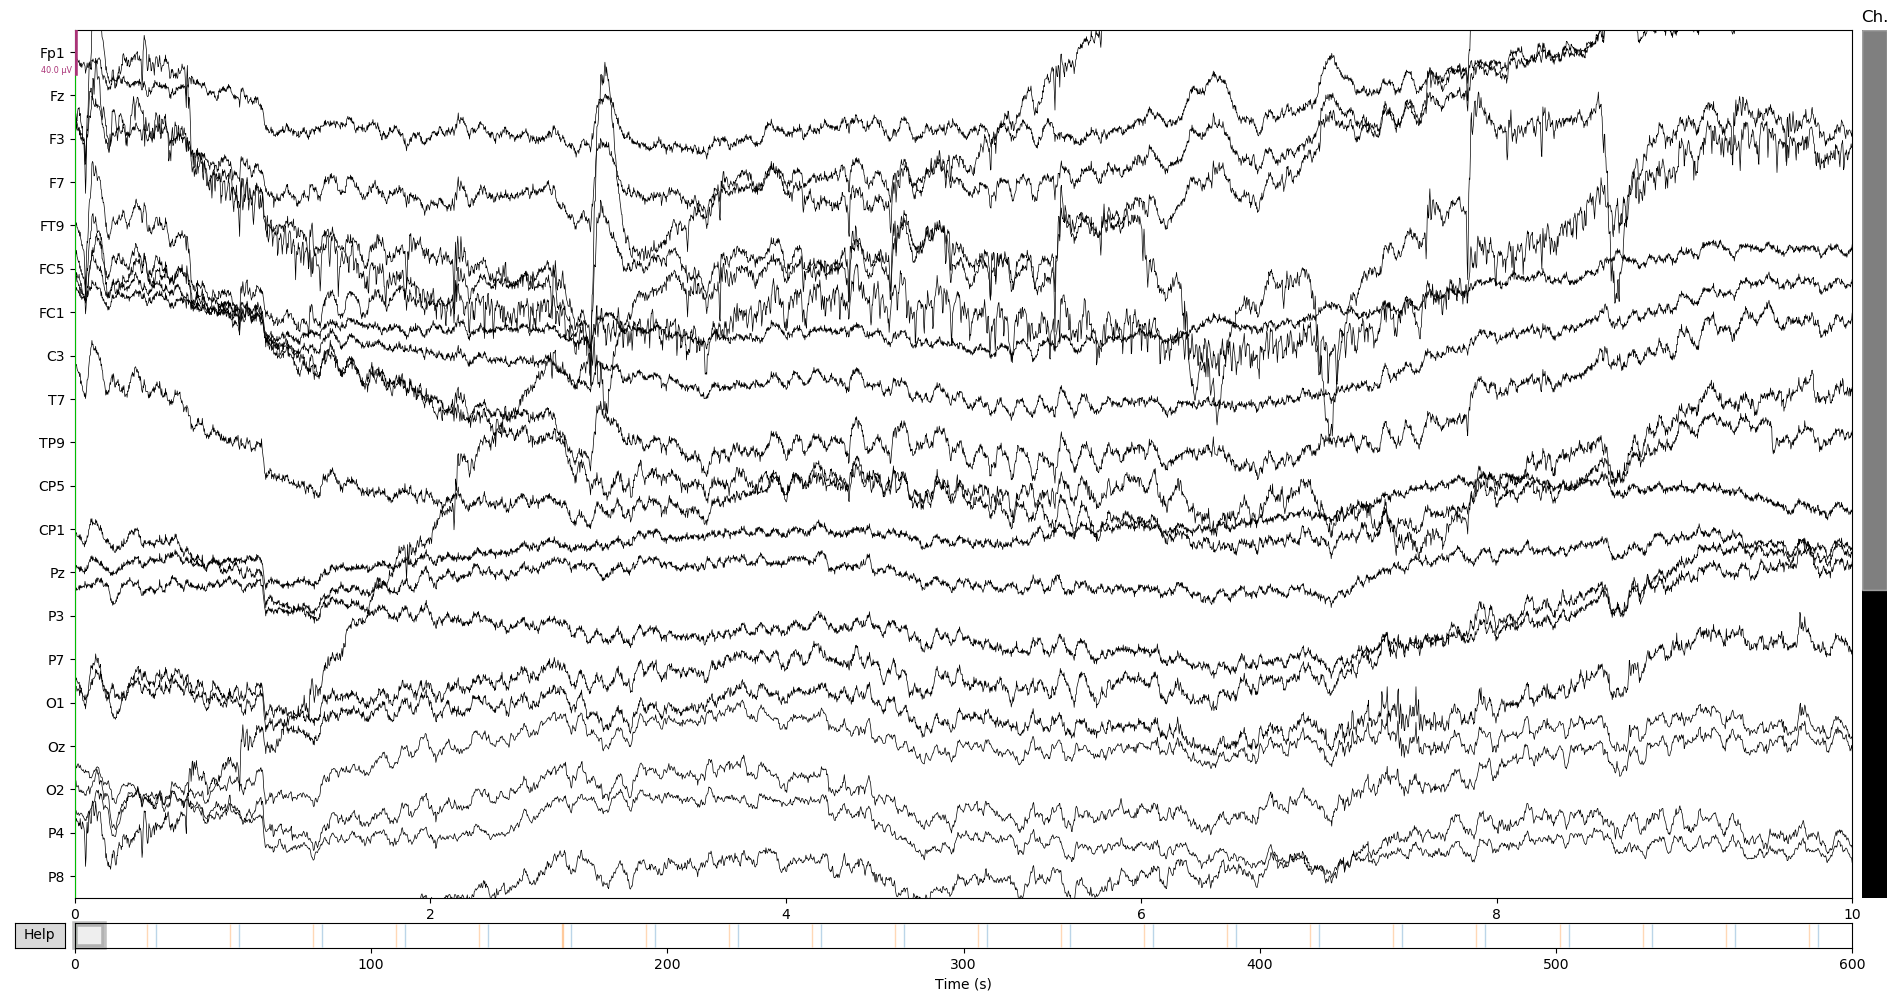

In [9]:
data.plot()

Effective window size : 2.048 (s)


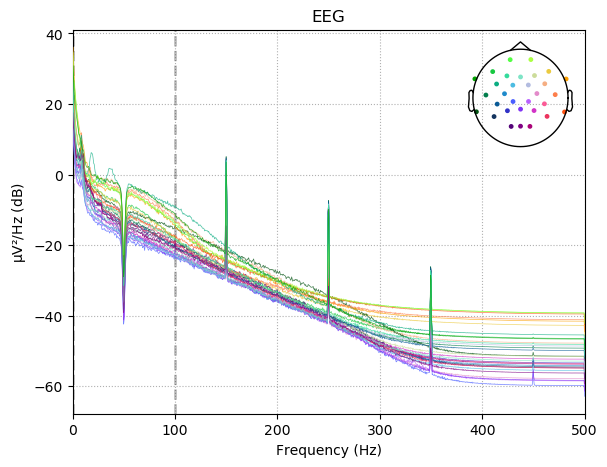

In [10]:
data.plot_psd()

# Filtering and ICA

In [10]:
data.filter(l_freq=1, h_freq=30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 sec)



<RawBrainVision | 03Wangyuwen.eeg, 31 x 600001 (600.0 s), ~142.0 MB, data loaded>

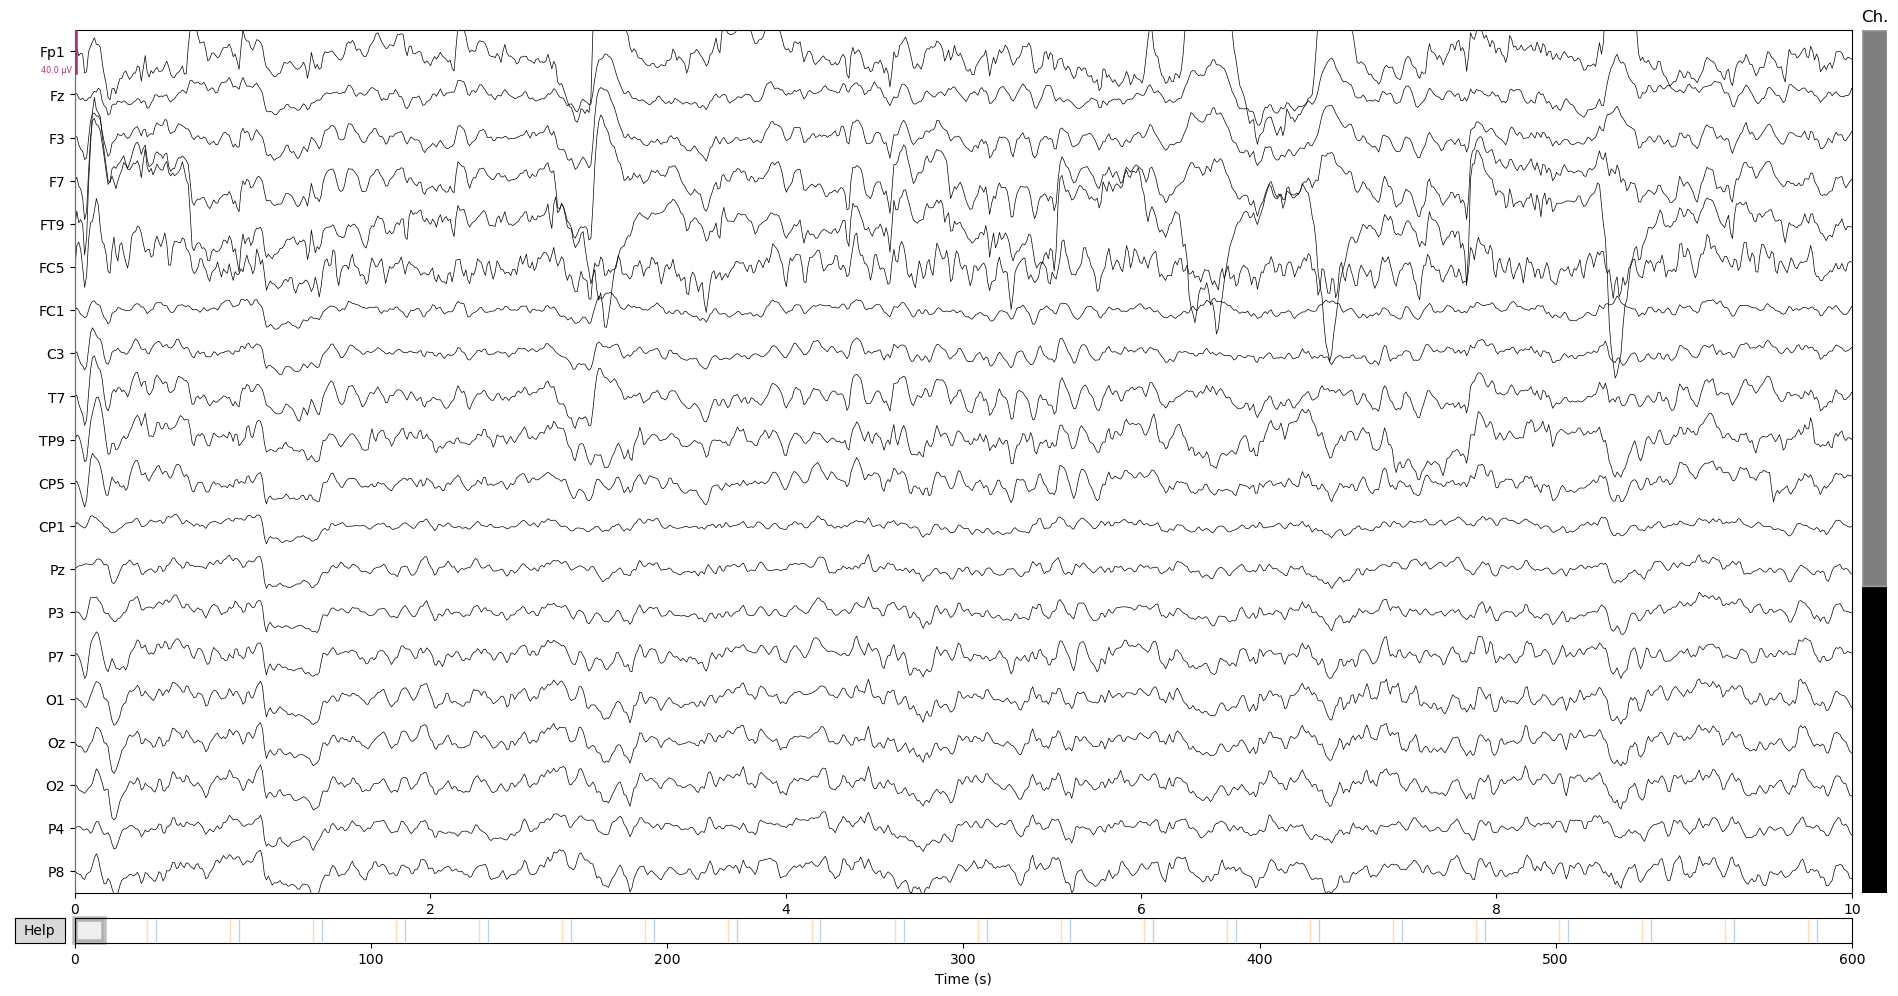

In [11]:
data.plot()

Effective window size : 2.048 (s)


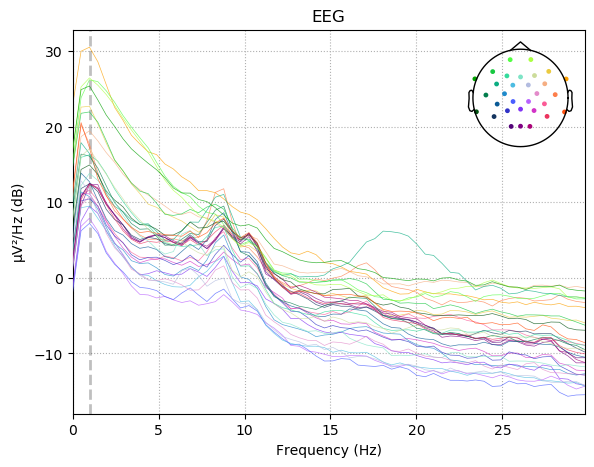

In [12]:
data.plot_psd(fmin=0,fmax=30)

In [14]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0)

In [ ]:
ica.fit(data.copy())

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 20 components


In [ ]:
ica.plot_components(outlines="skirt")

In [ ]:
# Automatically find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(data, 'FT10', 1.5)
print(eog_indices)

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
ica.plot_properties(data, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(data)

In [ ]:
# Manually exclude
eog_indices = [0, 1, 2, 5, 7, 9, 23, 24]
ica.exclude = eog_indices

In [ ]:
data_after_ica = ica.apply(data.copy(), exclude=ica.exclude)

In [ ]:
data_after_ica.plot()

# Epochs

In [39]:
events = mne.events_from_annotations(data)
events

Used Annotations descriptions: ['Stimulus/S 13', 'Stimulus/S 16']


(array([[ 84368,      0,     16],
        [ 87384,      0,     13],
        [112415,      0,     16],
        [115432,      0,     13],
        [140462,      0,     16],
        [143479,      0,     13],
        [168510,      0,     16],
        [171526,      0,     13],
        [196557,      0,     16],
        [199573,      0,     13],
        [224604,      0,     16],
        [227621,      0,     13],
        [252651,      0,     16],
        [255668,      0,     13],
        [280699,      0,     16],
        [283715,      0,     13],
        [308746,      0,     16],
        [311762,      0,     13],
        [336793,      0,     16],
        [339810,      0,     13],
        [364840,      0,     16],
        [367857,      0,     13],
        [392888,      0,     16],
        [395904,      0,     13],
        [420935,      0,     16],
        [423951,      0,     13],
        [448982,      0,     16],
        [451999,      0,     13],
        [477029,      0,     16],
        [48004

In [40]:
events[0].shape

(42, 3)

In [41]:
mne.viz.plot_events(events[0])

In [42]:
# event_ids = {"standard/stimulus": 200, "target/stimulus": 100}
# Here we prepare for classification, keys in this disctionary are actually labels for data categories.
# For example, {"L": 11, "M": 12, "H": 13}

event_ids = {"standard/stimulus":16, "target/stimulus": 13}

epochs = mne.Epochs(data, events[0], event_id=event_ids)

42 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 42 events and 701 original time points ...
0 bad epochs dropped
Loading data for 42 events and 701 original time points ...
Loading data for 20 events and 701 original time points ...


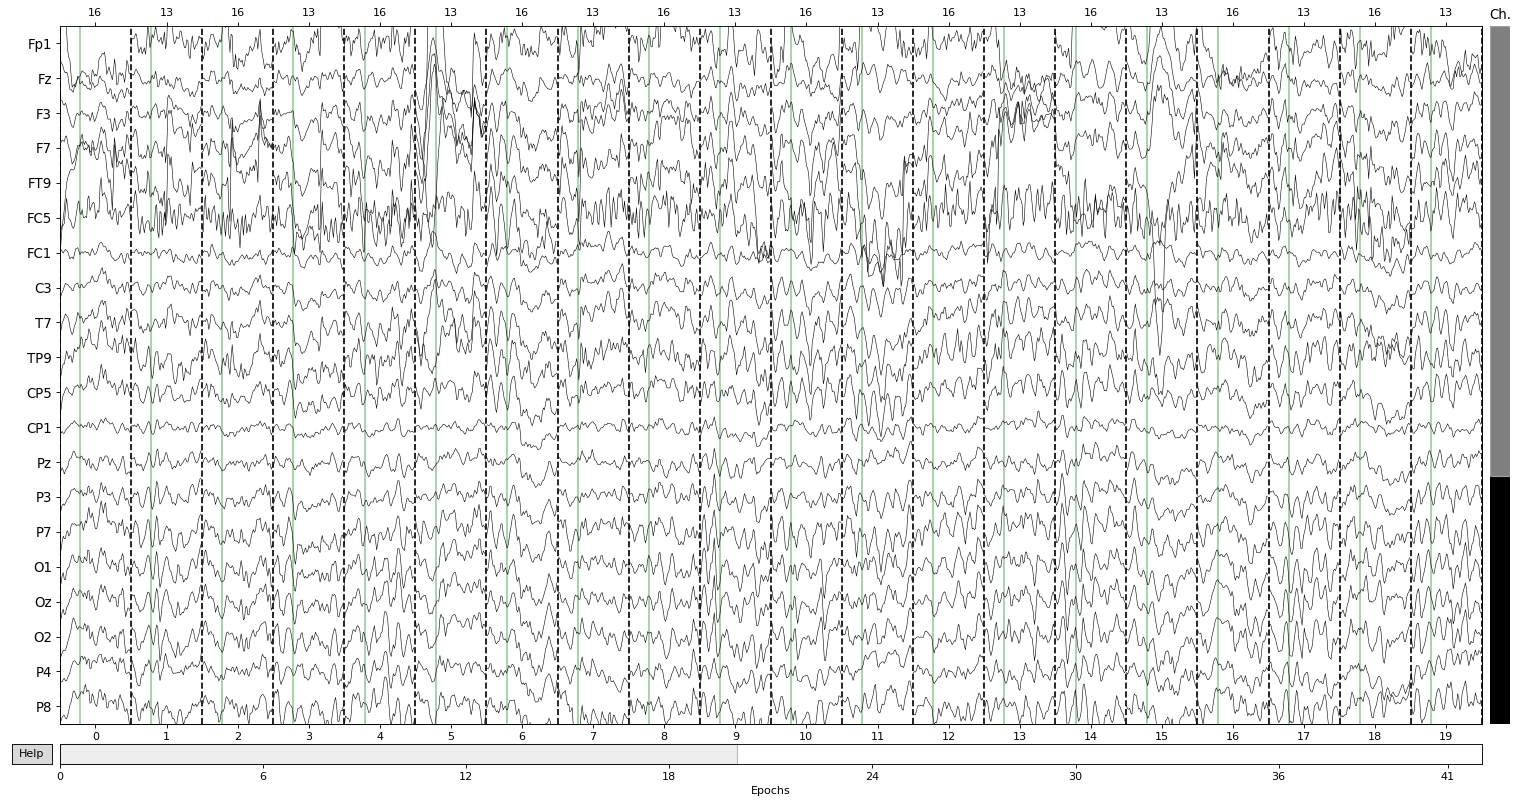

In [43]:
epochs.plot()

In [44]:
%matplotlib inline

In [47]:
# # epochs.load_data()
# # epochs = ica.apply(epochs, exclude=ica.exclude)
# epochs = mne.Epochs(data, events[0], event_id=event_ids, preload=True)
# epochs = ica.apply(epochs, exclude=ica.exclude)

In [48]:
epochs.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<Epochs  |   42 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~7.0 MB, data loaded,
 'standard/stimulus': 21
 'target/stimulus': 21>

21 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


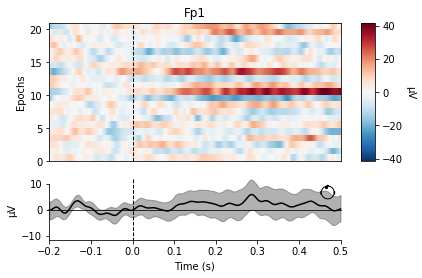

[<Figure size 432x288 with 4 Axes>]

In [51]:
epochs["target"].plot_image(picks=[0])

In [52]:
epochs.save("./cleaned-epo.fif",overwrite=True)

# Classification of Events

In [53]:
mne.set_log_level(True)

event_ids = {"target/stimulus": 13}

In [54]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [55]:
epochs.pick_types(eeg=True)
X = epochs.get_data()  # features
y = epochs.events[:, -1] == event_ids["target/stimulus"]  # targets
X.shape, y.shape

((42, 31, 701), (42,))

In [56]:
epochs.events[:, -1]

array([16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16,
       13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13, 16, 13,
       16, 13, 16, 13, 16, 13, 16, 13])

In [57]:
event_ids["target/stimulus"]

13

In [58]:
y

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True])

In [59]:
from mne.decoding import Vectorizer
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    LinearSVC(class_weight="balanced")
                   )

In [60]:
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x000001823775B388>),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [61]:
clf.predict(X[:9])

array([False,  True, False,  True, False,  True, False,  True, False])

In [62]:
cross_val_score(clf, X, y)  # accuracy

array([0.44444444, 0.55555556, 0.625     , 0.625     , 0.75      ])